# Assessing MLE convergence

In [40]:
import itertools
import jax.numpy as np
import matplotlib.pyplot as plt
import mushi.optimization as opt
from gcdyn.model import Model
from gcdyn.parameters import Parameters
from jax import jit, grad
from tqdm.auto import tqdm

## Demo usage of gcdyn module

In [44]:
θ = np.array([3, 1, 0, 0], dtype=float)
seed = 0
μ = 1
m = 1
ρ = 0.5
T = 3
n_trees = 2

params = Parameters(θ, μ, m, ρ)
model = Model(params)

model.simulate(T, n_trees, seed, False, 50, 96)

mle = model.fit()
print(f"Solution: {mle}")

initial objective 2.184769e+02
iteration 1000, objective 2.181e+02, relative change 4.131e-12                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
maximum iteration 1000 reached with relative change in objective function 4.1e-12
Solution: [3.23985356 1.07644249 0.28086724 0.        ]


## Code to get a traceplot of a single MLE run

In [ ]:
def MLE_trace(model, init_value, num_iters = 1000, plot_trace = True):
    """Computes the MLE of θ for the trees in `model`, and also provides a trace of log likelihood values over iterations."""

    init_value = np.array(init_value, dtype = float)

    grad_g = jit(grad(model.g))
    optimizer = opt.AccProxGrad(model.g, grad_g, model.h, model.prox, verbose=True)
    optimizer._initialize(init_value)

    log_lik_trace = []

    for iter in tqdm(range(num_iters), desc = "Optimization iter"):
        optimizer._step()
        log_lik_trace.append(-optimizer.f())

    if plot_trace:
        x_array = np.arange(num_iters) + 1        
        plt.plot(x_array, log_lik_trace)
        plt.xlabel("Iteration")
        plt.ylabel("log likelihood")
        plt.show()

    return optimizer.x, np.array(log_lik_trace)

Optimization iter:   0%|          | 0/1000 [00:00<?, ?it/s]

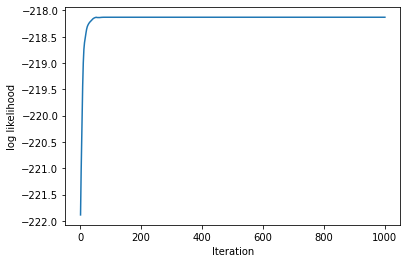

Solution: [3.24026958 1.07603546 0.2812921  0.        ]


In [43]:
mle, trace = MLE_trace(model, init_value = (1, 1, 1, 1))
print(f"Solution: {mle}")

## Code to try different initial values for MLE runs

Note that this still assumes a single model with a fixed $θ$; we just try to run the algorithm from different starting points.

In [38]:
def try_init_values(model, true_θ, *search_ranges, max_iter = 1000):
    """
    Runs MLE algorithm for `model` starting from points in the specified range of initial values,
    and plots the resulting log likelihoods against the distance of the initial value from the true parameter value.
    """
    search_space = itertools.product(*search_ranges)
    search_space = [np.array(t, dtype = float) for t in search_space]

    magnitudes = []
    log_liks = []

    skipped_values = []

    grad_g = jit(grad(model.g))
    optimizer = opt.AccProxGrad(model.g, grad_g, model.h, model.prox, verbose=False)

    for θ_init in tqdm(search_space, desc = "Init value #"):
        try:
            optimizer.run(θ_init, max_iter = max_iter, tol = 0)

            magnitudes.append(np.sqrt(np.power(θ - θ_init, 2).sum()))
            log_liks.append(-optimizer.f())

        except RuntimeError:
            skipped_values.append(θ_init)

    magnitudes = np.array(magnitudes)
    log_liks = np.array(log_liks)

    plt.scatter(magnitudes, log_liks)
    plt.xlabel(r"$||\theta - \theta\_init||$")
    plt.ylabel("log likelihood of result")
    plt.show()

    if skipped_values:
        print("Note: the following initial values were skipped:")

        for val in skipped_values:
            print(val)

Init value #:   0%|          | 0/625 [00:00<?, ?it/s]

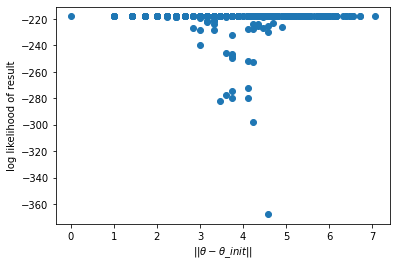

Note: the following initial values were skipped:
[0. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 2. 0.]
[0. 0. 3. 0.]
[0. 0. 4. 0.]
[0. 1. 0. 0.]
[0. 1. 1. 0.]
[0. 1. 2. 0.]
[0. 1. 3. 0.]
[0. 1. 4. 0.]
[0. 2. 0. 0.]
[0. 2. 1. 0.]
[0. 2. 2. 0.]
[0. 2. 3. 0.]
[0. 2. 4. 0.]
[0. 3. 0. 0.]
[0. 3. 1. 0.]
[0. 3. 2. 0.]
[0. 3. 3. 0.]
[0. 3. 4. 0.]
[0. 4. 0. 0.]
[0. 4. 1. 0.]
[0. 4. 2. 0.]
[0. 4. 3. 0.]
[0. 4. 4. 0.]


In [45]:
try_init_values(model, θ, range(0, 5), range(0, 5), range(0, 5), range(0, 5))

## MLE on BEAST trees

In [ ]:
import pickle

with open("tenseqs_subset-ete3_trees.pickle", "rb") as trees_file:
    beast_trees = pickle.load(trees_file).values()

Work in progress...